## Helper

In [1]:
import wandb 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
select_group  = lambda runs,group:[run for run in runs if run.group == group]
def calc_mean_std_auc(runs_for_auc):
    auc = [runs.history()["auc"].dropna() for runs in runs_for_auc]
    return round(np.array(auc).mean(),3),round(np.array(auc).std(),3)

def plot_loss(runs, metric="loss"):
    if metric == "loss":
        metric_train = "Loss train"
        metric_val = "Loss val"
        label = "Loss"
    elif metric == "auc":
        metric_train = "auc_train"
        metric_val = "auc_val"
        label = "Auc"
    
    loss_train_val = pd.concat([run.history().loc[:, [metric_train, metric_val, "epoch"]].dropna() for run in runs])
    
    # Calculate mean and std separately for metric_train and metric_val
    mean_std_train = loss_train_val.groupby("epoch")[metric_train].agg(mean='mean', std='std')
    mean_std_val = loss_train_val.groupby("epoch")[metric_val].agg(mean='mean', std='std')
    
    # Reset index for both mean_std_train and mean_std_val
    mean_std_train.reset_index(inplace=True)
    mean_std_val.reset_index(inplace=True)
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Plot mean values as lines for metric_train and metric_val
    sns.lineplot(x='epoch', y='mean', data=mean_std_train, label=f'Mean {label} (Train)')
    sns.lineplot(x='epoch', y='mean', data=mean_std_val, label=f'Mean {label} (Validation)')
    
    # Fill between mean - std and mean + std to represent std as shaded regions for both
    plt.fill_between(mean_std_train['epoch'], mean_std_train['mean'] - mean_std_train['std'], mean_std_train['mean'] + mean_std_train['std'], alpha=0.2, label=f'Std {label} (Train)')
    plt.fill_between(mean_std_val['epoch'], mean_std_val['mean'] - mean_std_val['std'], mean_std_val['mean'] + mean_std_val['std'], alpha=0.2, label=f'Std {label} (Validation)')
    
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.title(f'{label} Train vs. {label} Validation')
    plt.show()
def plot_auc(runs_diff_group):
    auc_values_list = [[run.history()["auc"].dropna().values[0] for run in runs] for runs in runs_diff_group]
    names = [runs[0].group for runs in  runs_diff_group]
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    for i, auc_values in enumerate(auc_values_list):
        stripplot = sns.stripplot(x=[i] * len(auc_values), y=auc_values, jitter=False, dodge=False, alpha=1, size=8)
        sns.pointplot(x=[i] * len(auc_values), y=auc_values, errorbar="sd", markers="o", capsize=0.2, label=names[i])

    # Draw a horizontal line at 0.5
    plt.axhline(y=0.5, color='red', linestyle='--', label='Random (0.5)')

    # Customize the plot
    plt.xticks(range(len(auc_values_list)), [names[i] for i in range(len(auc_values_list))])
    plt.xlabel('Runs')
    plt.ylabel('AUC')
    plt.title('AUC-values with 1 standard deviation')
    plt.ylim(0, 1)  # Set y-axis limits to start from 0 and go up to 1
    plt.legend()
    plt.show()

## MRI

In [3]:
runs = wandb.Api().runs(f"pro5d-classification-prolactinoma/MRI-Modell")
baseline_mlp_runs = select_group(runs,"Baseline MLP")
baseline_mlp_test_runs = select_group(runs,"Baseline_MLP_Test") 

baseMed3d_weighted = select_group(runs,"BaseMed3d_weighted")

baseline_resnet = select_group(runs,"Baseline Resnet")
resnet_weighted  = [run for run in select_group(runs,"Weighted") if run.config["model architecture"] == "Resnet 18"]


resnet_augmented_weighted = select_group(runs,"Augmented_weighted")
resnet_augmented_weighted_freezed = select_group(runs,"Augmented_weighted_freezed")

resnet_augmented_weighted_test  = select_group(runs,"Augmented_weighted_Test")

## Baseline MLP

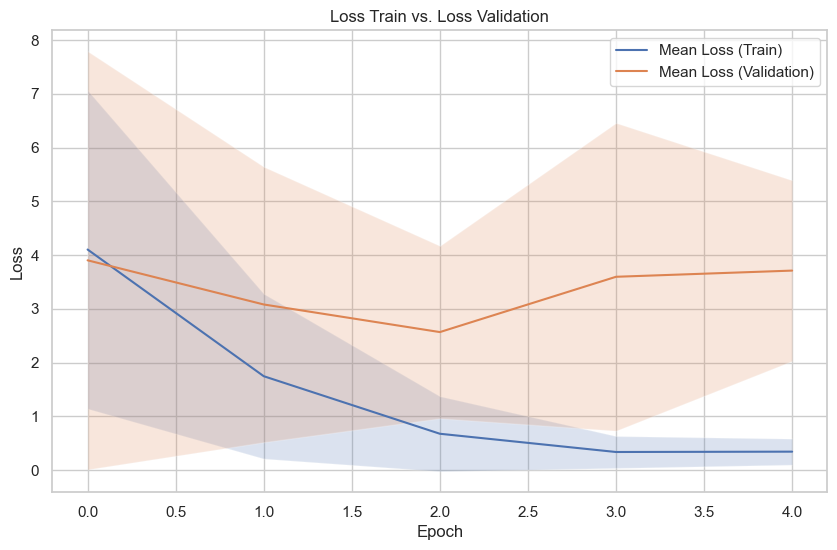

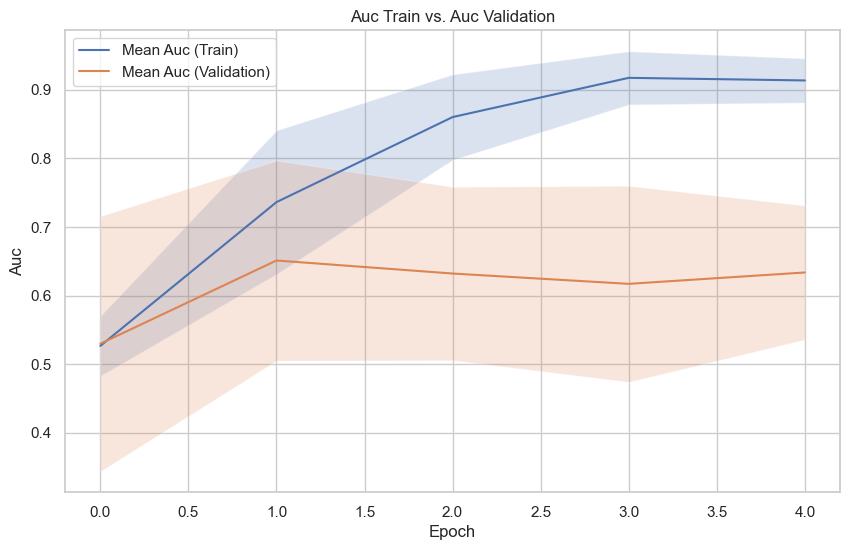

In [4]:
plot_loss(baseline_mlp_runs,"loss")
plot_loss(baseline_mlp_runs,"auc")

+ ROC Curve Test

### MED3D

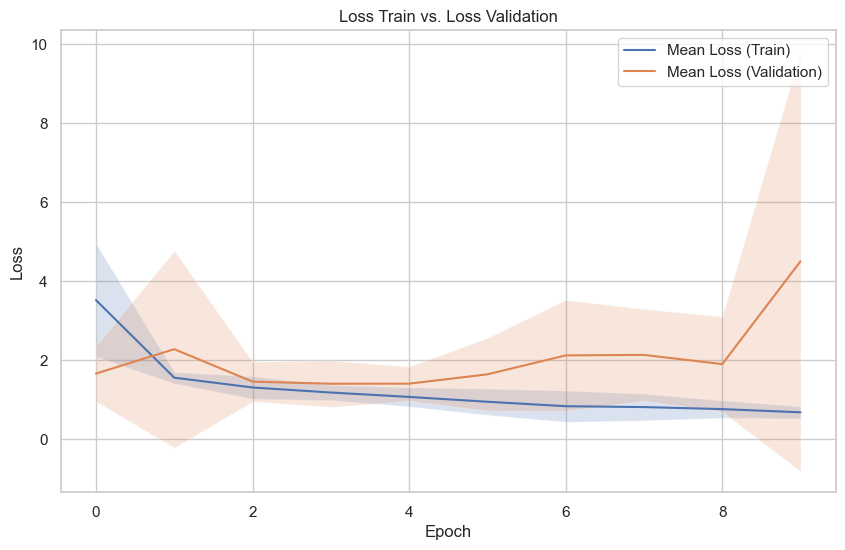

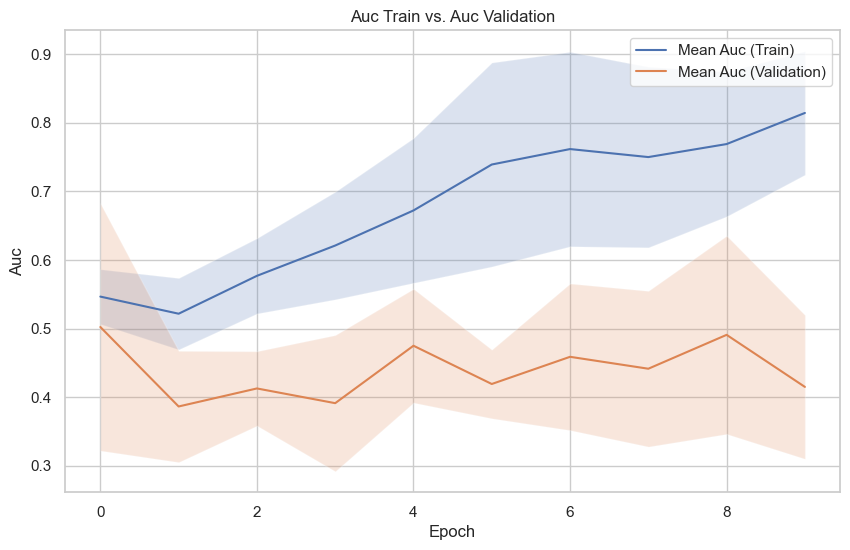

In [5]:
plot_loss(baseMed3d_weighted)
plot_loss(baseMed3d_weighted,"auc")

## Resnet

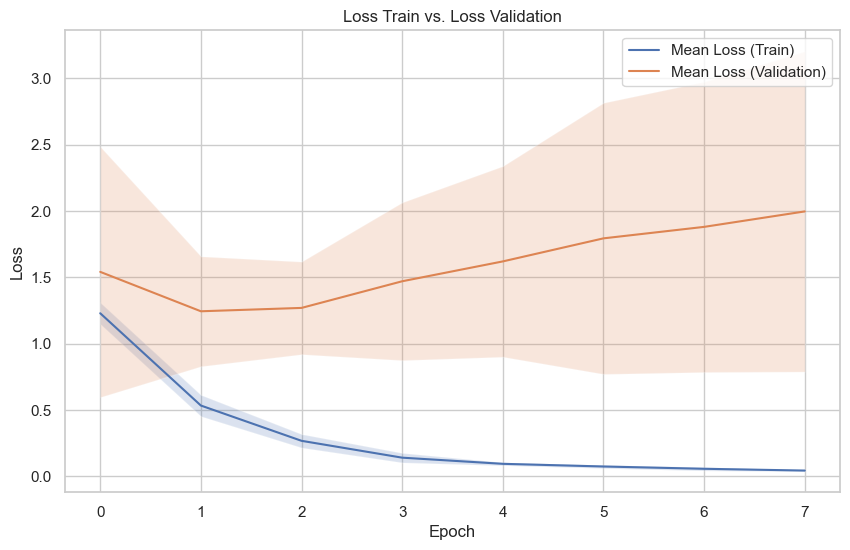

In [6]:
plot_loss(resnet_augmented_weighted,"loss")


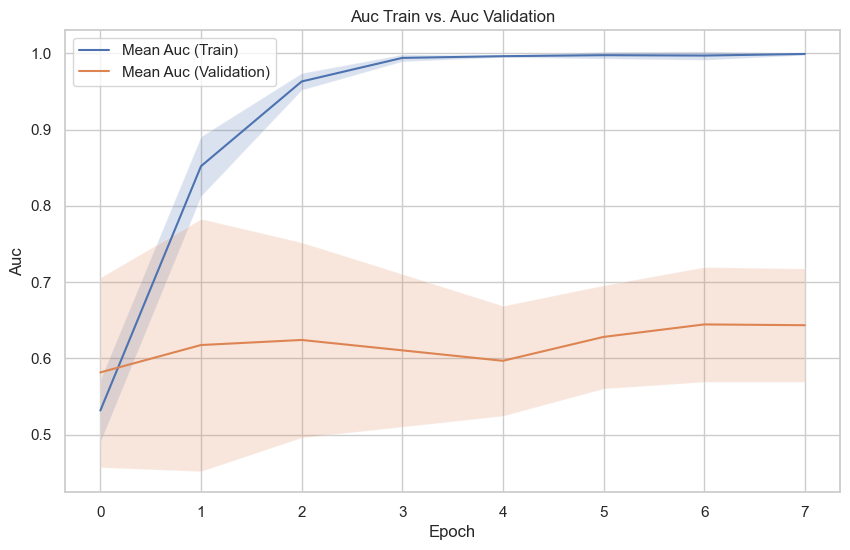

In [7]:
plot_loss(resnet_augmented_weighted,"auc")

## Test AUC

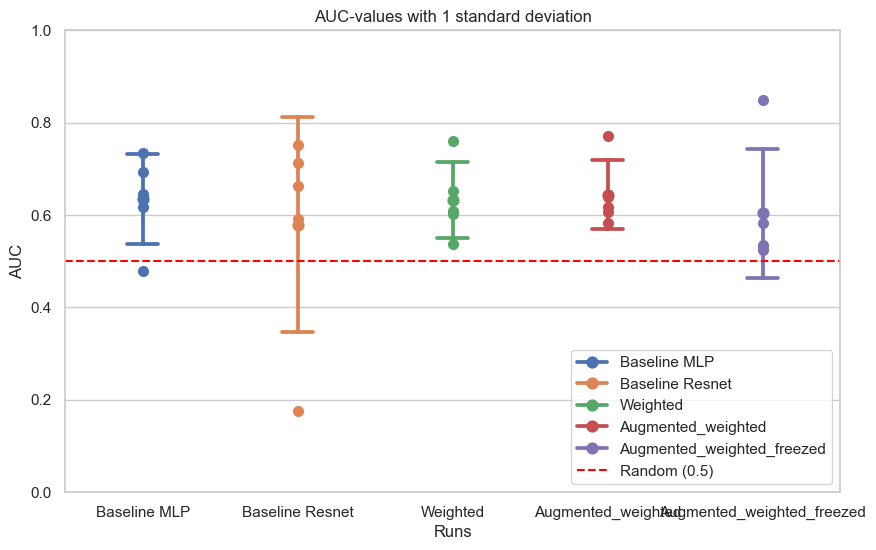

In [8]:
plot_auc([baseline_mlp_runs,baseline_resnet,resnet_weighted,resnet_augmented_weighted,resnet_augmented_weighted_freezed])

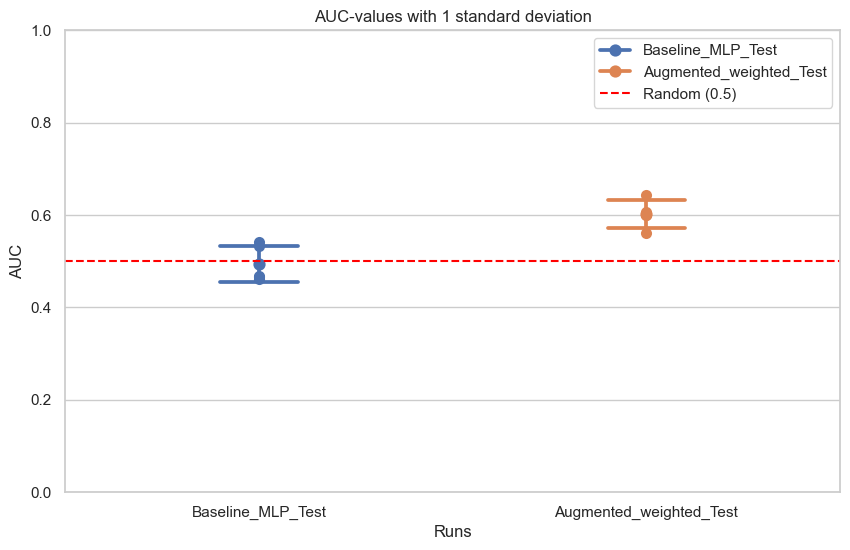

In [9]:
plot_auc([baseline_mlp_test_runs,resnet_augmented_weighted_test])

## LAB